# Cálculo de distancia entre puntos y caracterización previa de los movimientos

En este Notebook se calculan las distancias entre puntos del cuerpo y los ángulos de las distintas articulaciones según el gesto que esté realizando el paciente. Por ejemplo, si se detecta una flexión del hombro derecho, se calcularán las distancias ángulos relacionados con ese brazo.

Una vez realizados estos cálculos, se llevará a cabo una nueva hiperparametrización del pipeline de la Fase 2, con el objetivo de evaluar si esto mejora el rendimiento del modelo.

Finalmente, para comprender cómo se clasifica cada repetición de los gestos como correcta o incorrecta, se generarán gráficos que visualicen la importancia de las variables seleccionadas y cómo estas son utilizadas por el clasificador.


<div style="text-align: center;">
<img src="../Imagenes/gestures.png" width="500"/>
</div>

***• Importar librerías***

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fn
import numpy as np
from sklearn import tree # visualizar dtree
from scipy.special import expit # visualizar LogisticRegression

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut # LeavePGroupsOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV

# Class imbalance
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance


# Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer

# Suprimir warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

***• Importar datos***

In [9]:
# Dataframe de los datos en bruto
df_raw = pd.read_csv('../Resultados/raw_pacientes.csv', dtype=object)
df_raw 

SubjectID GestureLabel GestureName RepetitionNumber CorrectLabel  \
0             102            0         EFL               10            1   
1             102            0         EFL               10            1   
2             102            0         EFL               10            1   
3             102            0         EFL               10            1   
4             102            0         EFL               10            1   
...           ...          ...         ...              ...          ...   
5500495       307            8         STR                9            1   
5500496       307            8         STR                9            1   
5500497       307            8         STR                9            1   
5500498       307            8         STR                9            1   
5500499       307            8         STR                9            1   

        Position      JointName         3D_X         3D_Y      3D_Z  
0          chair      SpineBase  -0.08088344   -0.2248836  2.661578  
1          chair       SpineMid  -0.06806522   0.04492111  2.628779  
2          chair           Neck    -0.055614    0.3082771  2.583972  
3          chair           Head  -0.04478608    0.4328104  2.593495  
4          chair   ShoulderLeft   -0.2232155    0.2021449  2.549825  
...          ...            ...          ...          ...       ...  
5500495    stand  SpineShoulder  -0.05799517    0.5291457  2.422904  
5500496    stand    HandTipLeft    -0.302538   -0.1131345  2.284269  
5500497    stand      ThumbLeft   -0.2783904  -0.06298634  2.269769  
5500498    stand   HandTipRight    0.1525867    -0.136378   2.45287  
5500499    stand     ThumbRight    0.1846331  -0.06777165  2.436065  

[5500500 rows x 10 columns]

***• Funciones creadas***

In [10]:
def calcular_distancia(df: pd.DataFrame, joint_a: str, joint_b: str):
    # Extraer posiciones de los keypoints
    positions = df.set_index('JointName')[['3D_X', '3D_Y', '3D_Z']].loc[[joint_a, joint_b]]

    # Convertir las posiciones a tipo numérico
    positions = positions.apply(pd.to_numeric)

    # Vector u (joint_a to joint_b) y Vector v (joint_b to joint_c)
    u = np.array([positions.iloc[1, 0] - positions.iloc[0, 0],
                  positions.iloc[1, 1] - positions.iloc[0, 1],
                  positions.iloc[1, 2] - positions.iloc[0, 2]])

    modulo_u = np.linalg.norm(u)

    return modulo_u

In [11]:
# dividir en test y train df_gestures
def split_df_gestures(df:pd.DataFrame, target: str):

    # Selecciona los datos de prueba (varios sujetos)
    test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==201) |
                (df.SubjectID==202) | (df.SubjectID==205) | (df.SubjectID==302)] 

    # Selecciona los datos de entrenamiento excluyendo los mismos sujetos
    train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105)  & (df.SubjectID!=201) &
                    (df.SubjectID!=202) & (df.SubjectID!=205) & (df.SubjectID!=302)]

    # Separa las características y las etiquetas en el conjunto de entrenamiento
    X_train = train_df.drop([target], axis=1)  
    y_train = pd.DataFrame(train_df[target])   

    # Separa las características y las etiquetas en el conjunto de prueba
    X_test = test_df.drop([target], axis=1)  
    y_test = pd.DataFrame(test_df[target])   

    # Convierte los DataFrames de etiquetas a arrays 1D
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Devuelve los conjuntos de entrenamiento y prueba
    return X_train, X_test, y_train, y_test

***• Caracterización previa de los movimientos y Pipeline***

In [12]:
# Definir la malla de parámetros
param_grid = [
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5], 
        'classifier__weights': ['uniform', 'distance'], 
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -8, num=100)
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [SVC(probability=True)],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__C': [0.1, 1, 10, 100]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [200, 300],
        'classifier__max_features': ['sqrt', 'log2']
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    }
]

     ElbowAngleLeft  ShoulderAngleLeft  WristAngleLeft  \
125       26.401813         148.337657        8.231100   
126       26.594379         148.744274        7.760680   
127       26.753239         148.576072        8.066698   
128       26.735691         148.725585        6.875383   
129       26.824635         148.566369        5.338620   
..              ...                ...             ...   
194       26.112103         148.557813        6.761722   
195       26.230303         148.453033        5.475999   
196       26.257516         148.331111        5.207606   
197       25.736227         148.475419        4.899662   
198       25.693546         148.610031        5.572133   

     ElbowVerticalAngleLeft  WristVerticalAngleLeft  ShouldersDistance  \
125              150.255863              152.477918           0.339461   
126              149.926809              152.506218           0.336150   
127              150.042627              152.514022           0.337322   
128    

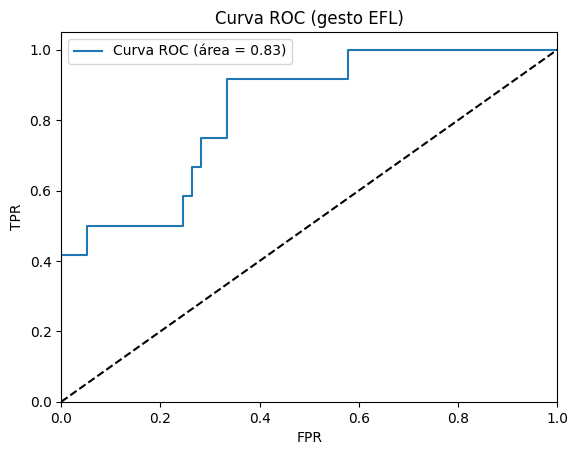

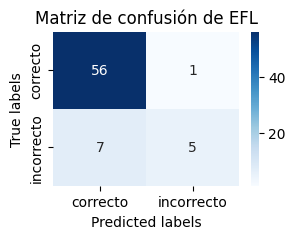

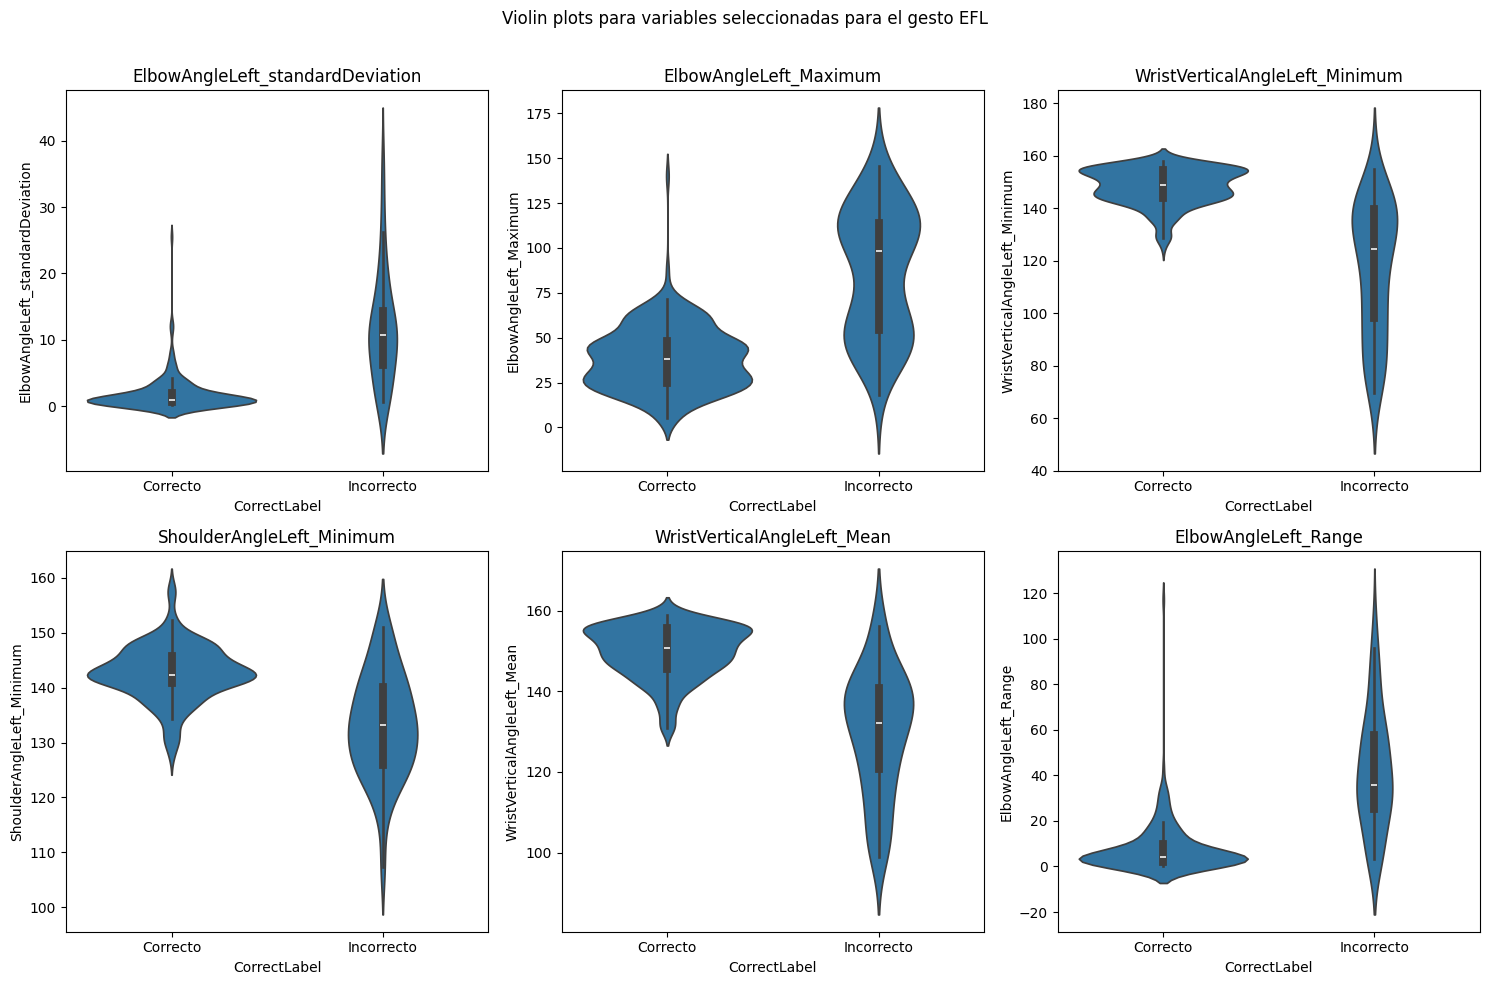

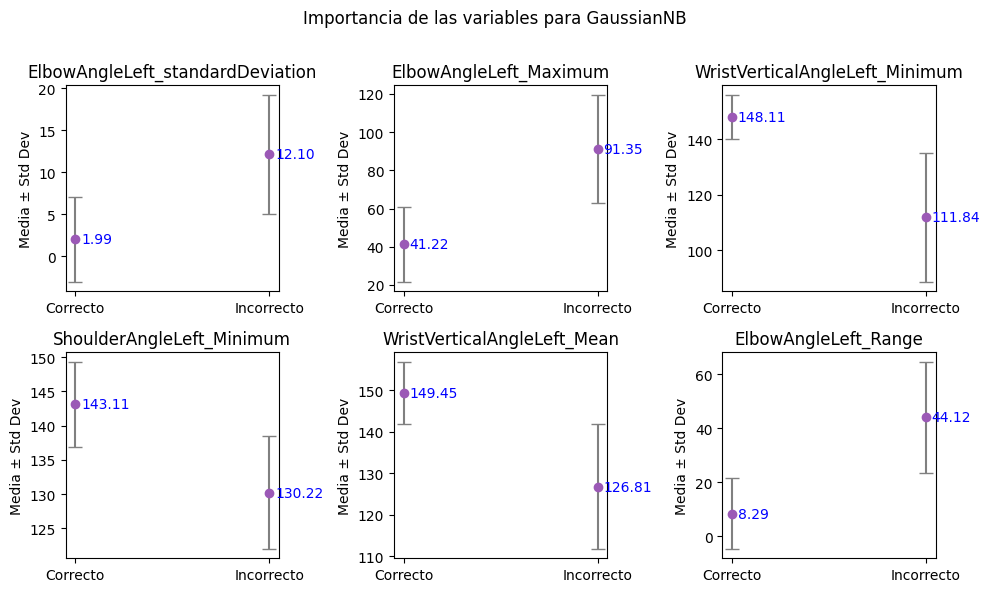

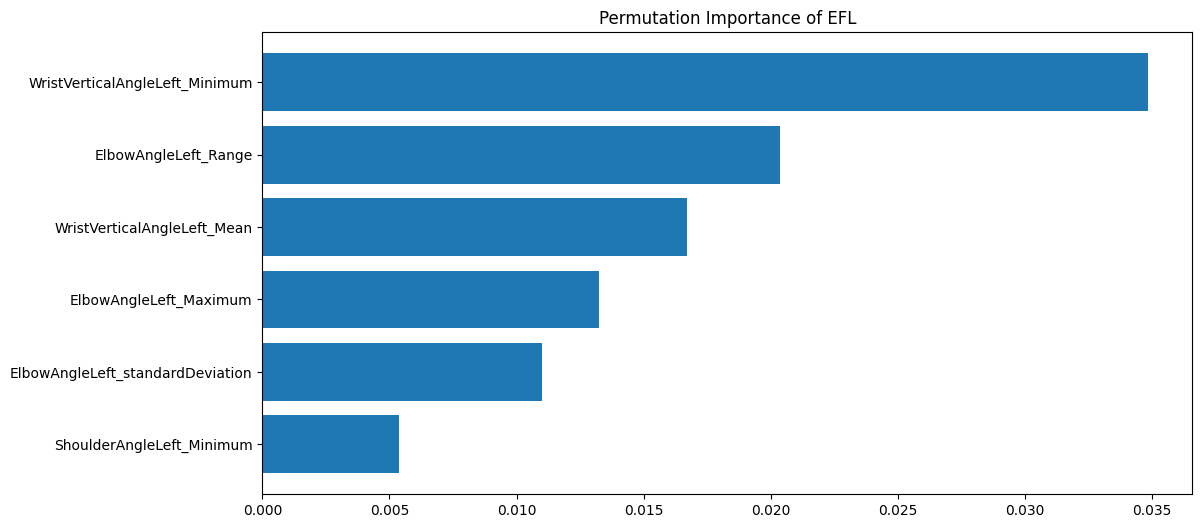

     ElbowAngleRight  ShoulderAngleRight  WristAngleRight  \
124        29.777437          150.361745        25.926768   
125        29.648477          150.385133        26.049072   
126        29.654360          150.414350        25.154267   
127        29.535201          150.451782        25.166563   
128        29.594853          150.438274        24.910824   
129        29.649993          150.439947        25.974124   
130        29.775061          150.446351        25.198504   
131        29.615142          150.498242        26.889729   
132        29.613756          150.490277        26.891976   
133        29.194381          150.488806        27.119882   
134        29.245008          150.510224        25.991538   
135        29.422988          150.549446        25.783969   
136        29.283810          150.585907        26.364128   
137        29.306744          150.591829        25.628303   
138        29.454754          150.585488        25.650080   
139        29.569319    

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


F1-score del conjunto de entrenamiento: 0.8715083798882681
F1-score del conjunto de prueba: 0.8735632183908046
Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest()),
                ('classifier',
                 GaussianNB(var_smoothing=1.1768119524349966e-05))])


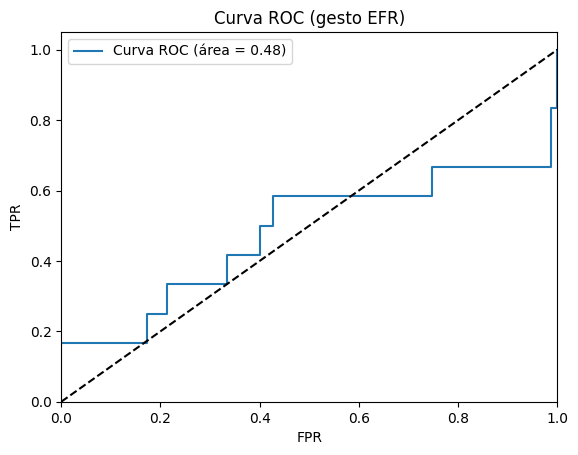

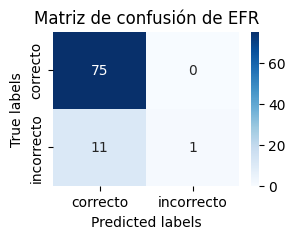

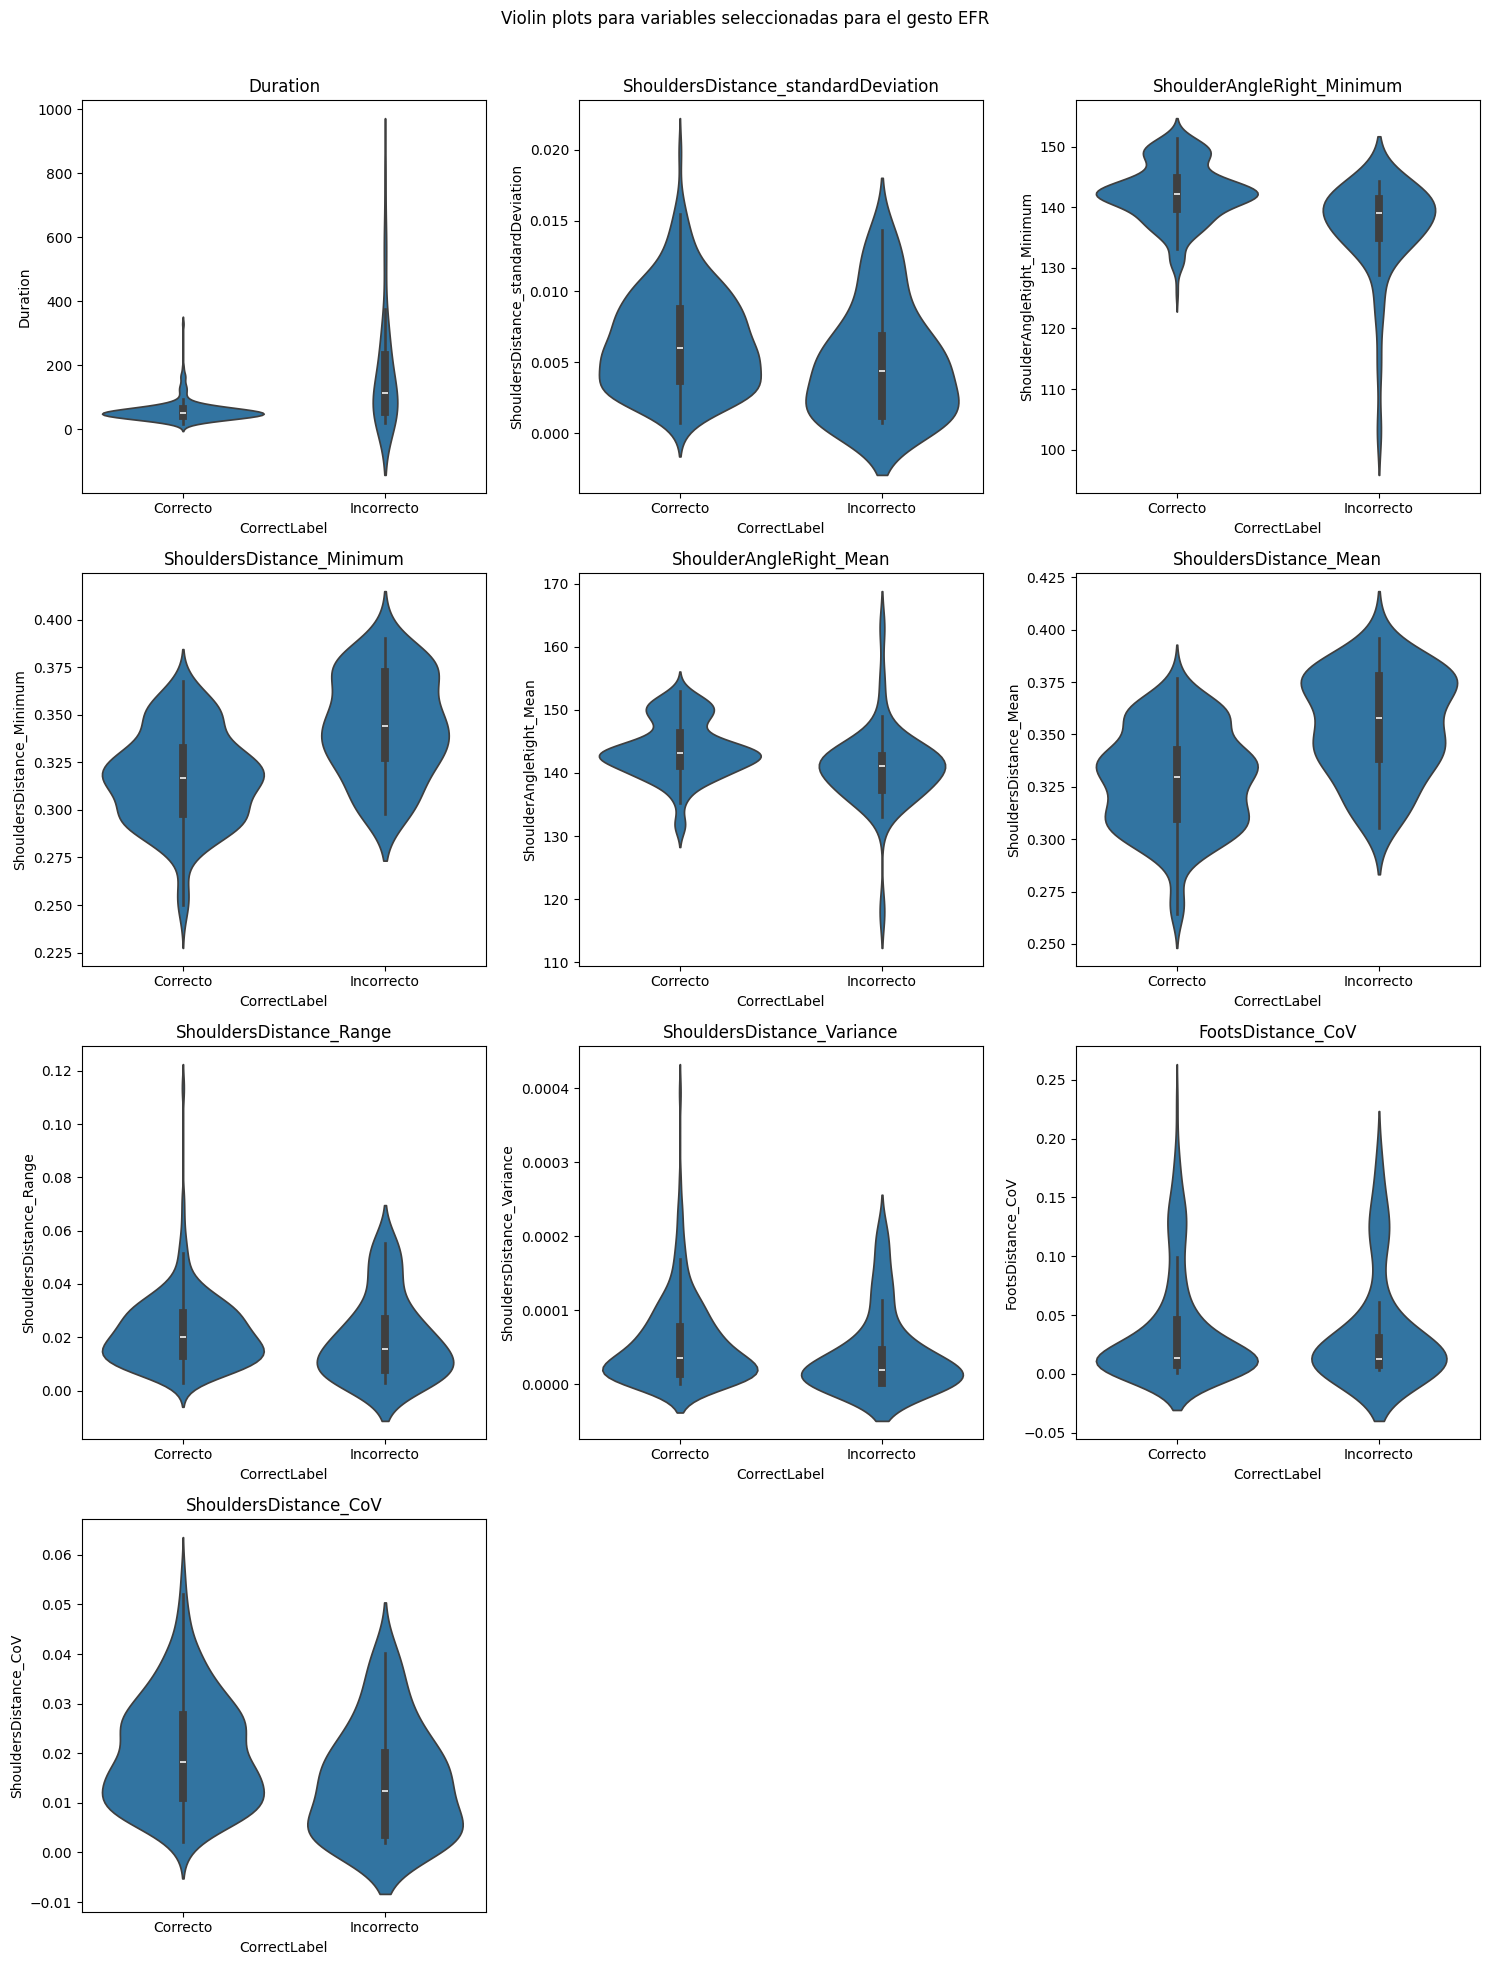

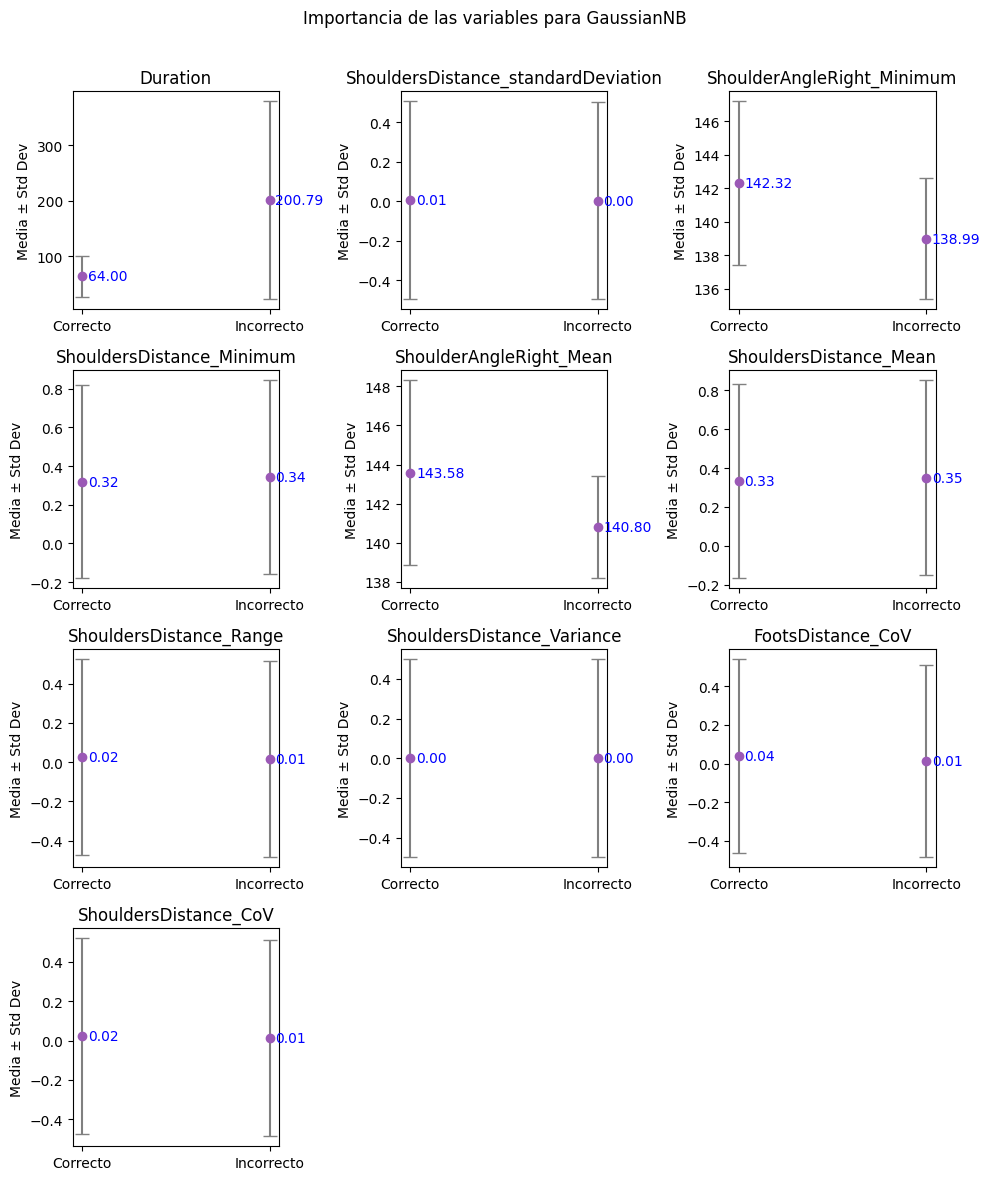

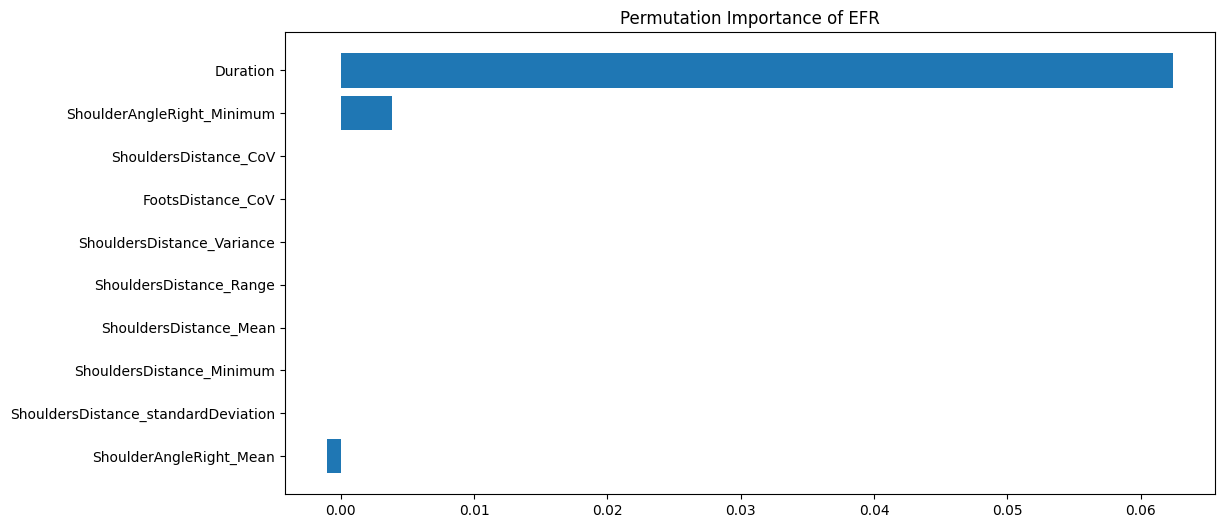

     ElbowAngleLeft  ShoulderAngleLeft  WristAngleLeft  \
183       26.275038         147.365332        9.395151   
184       26.115621         147.310626        9.370013   
185       25.872077         147.369591        9.478388   
186       25.401323         147.310350       10.638033   
187       25.015864         147.432388       10.553557   
188       24.958513         147.543824        1.876183   
189       24.084298         147.548519        6.459384   
190       23.507800         147.478991        5.568240   
191       23.659772         147.463993        5.474981   
192       24.036474         147.386004        5.692240   
193       25.279151         147.665133        6.014465   
194       25.655792         147.276600        6.646526   
195       25.928232         147.420376        6.595904   
196       26.157701         147.495708        7.674347   
197       26.524690         147.420670        8.011090   
198       26.982667         147.446566        9.669252   
199       27.1

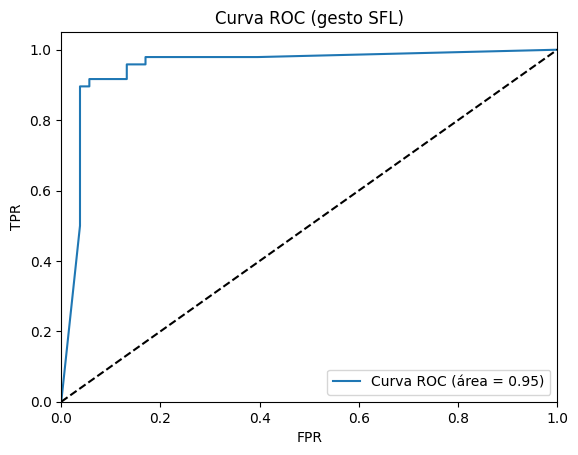

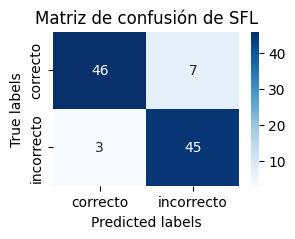

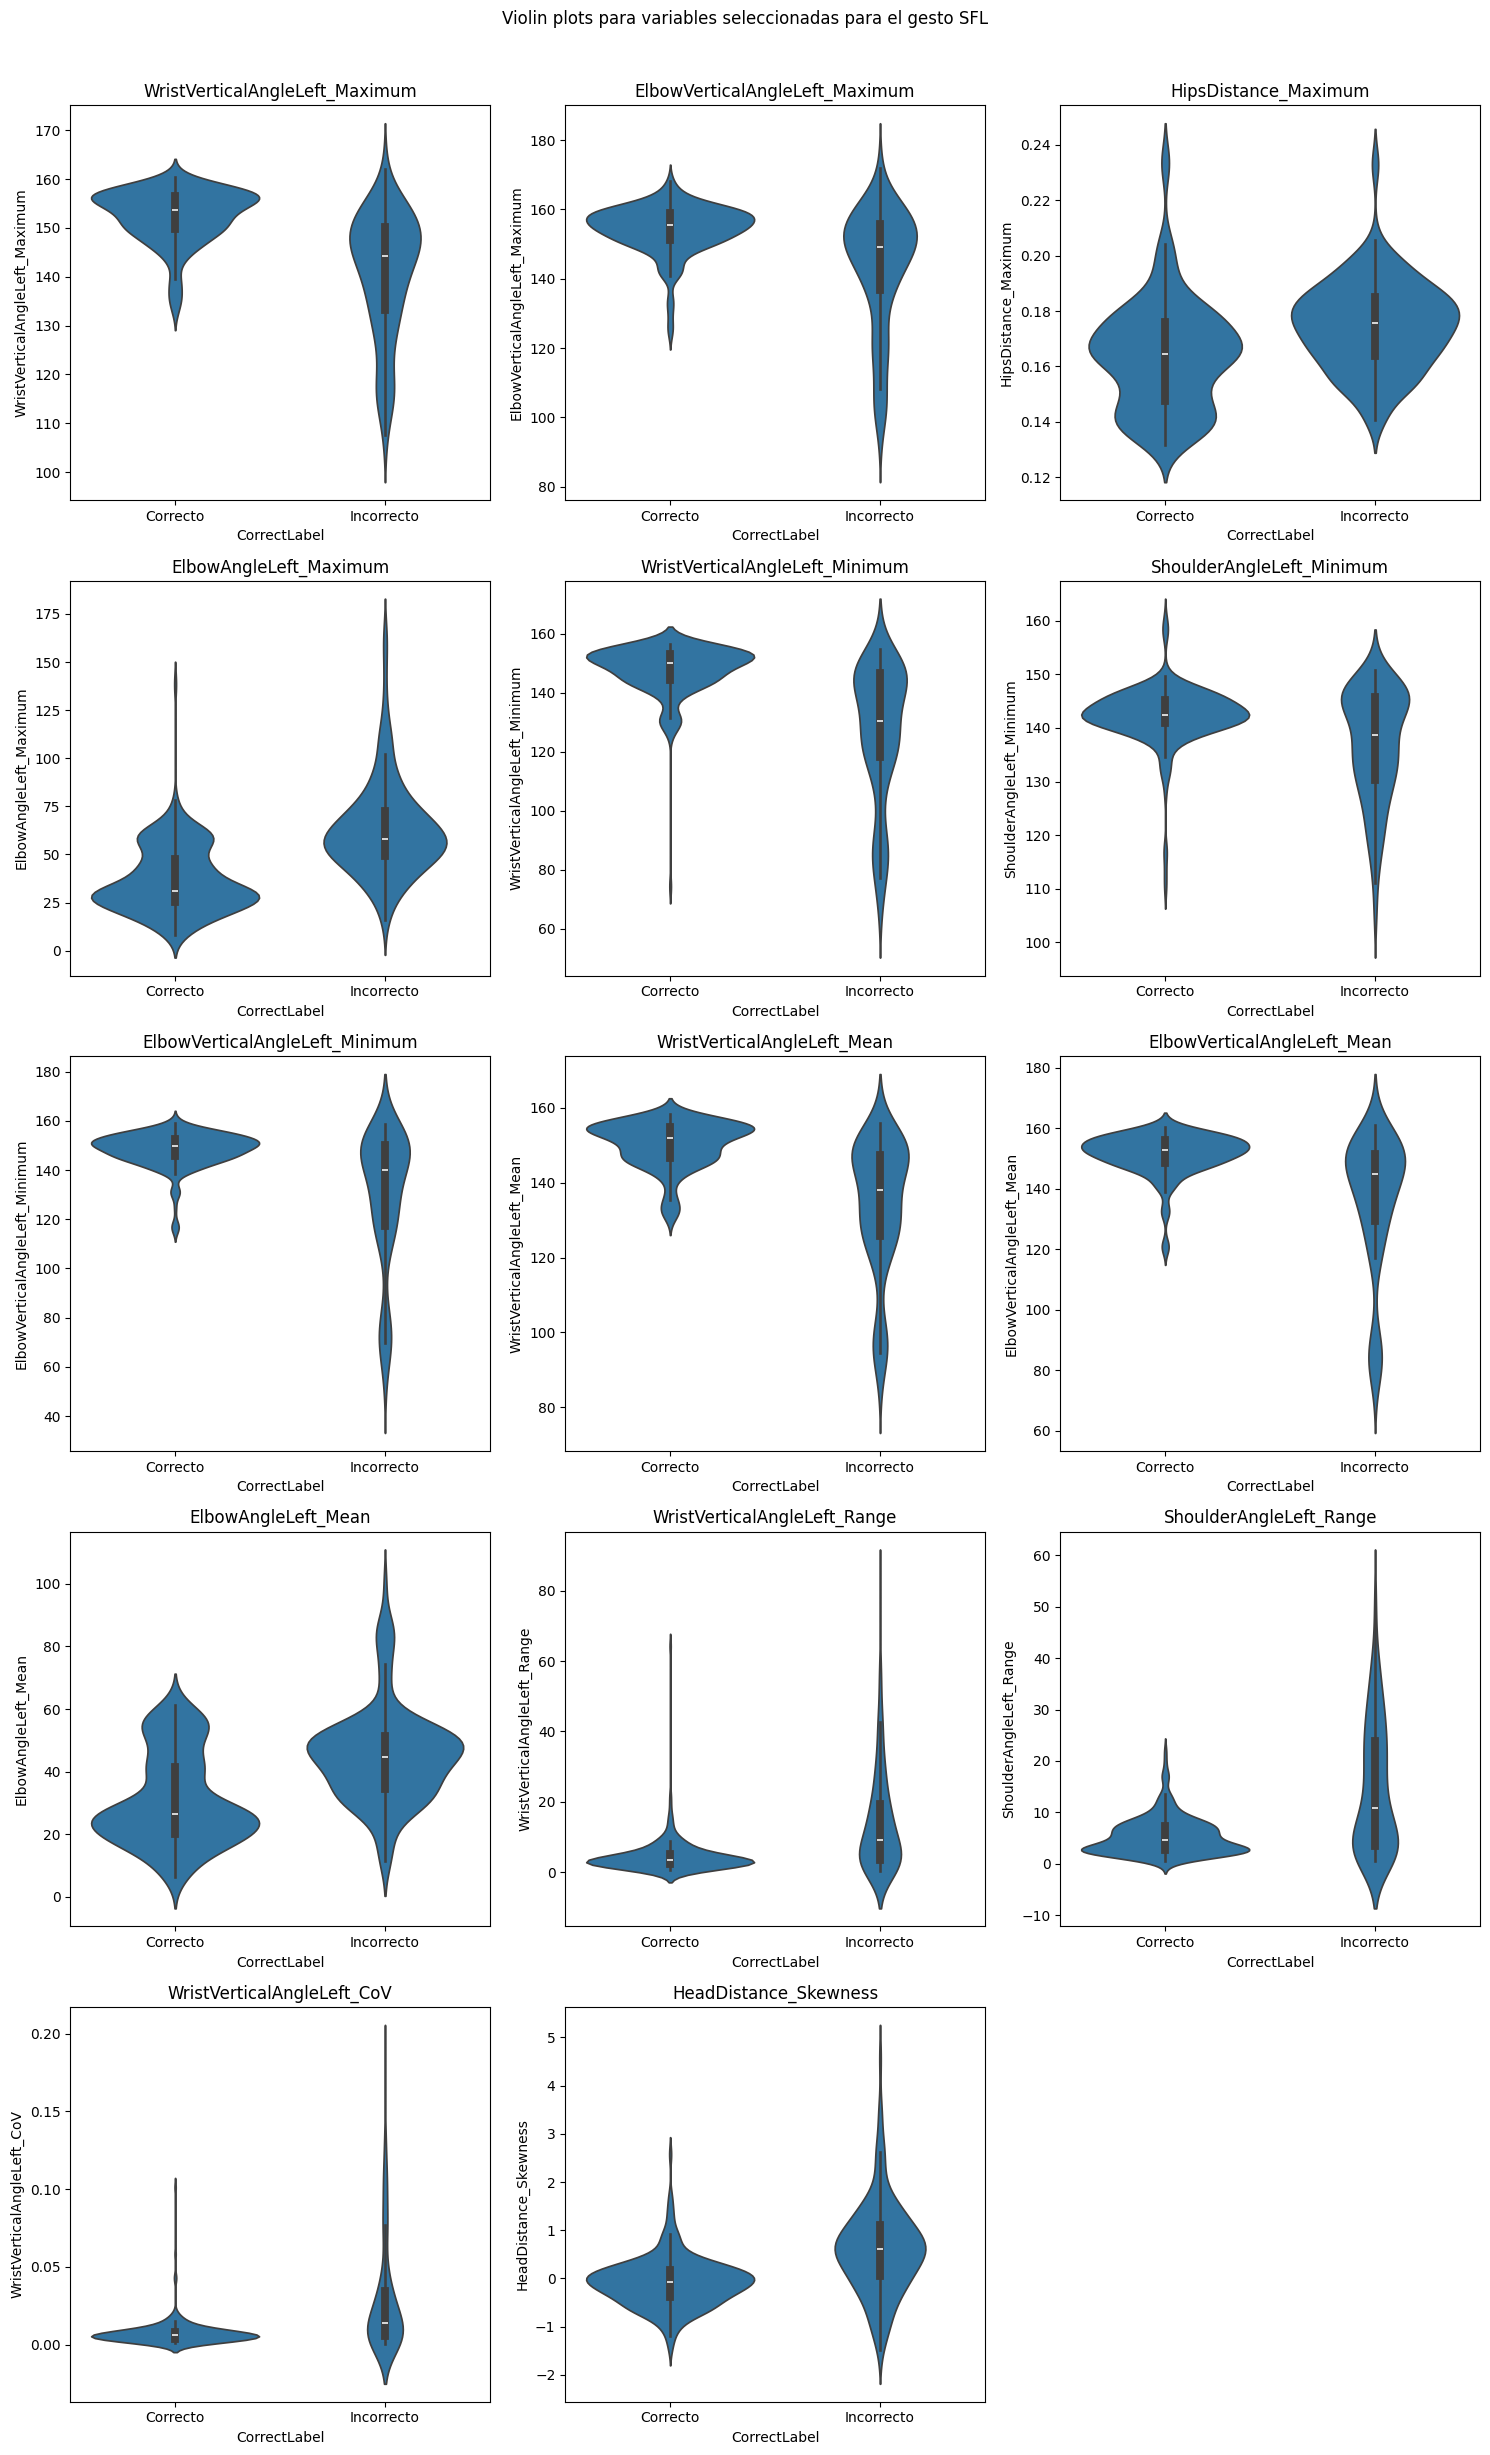

<Figure size 640x480 with 0 Axes>

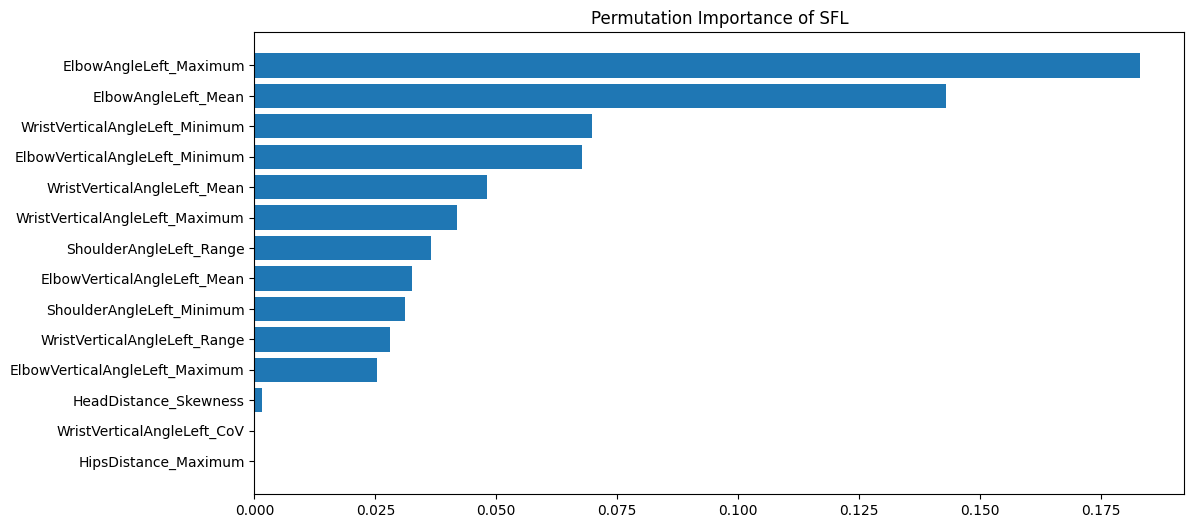

     ElbowAngleRight  ShoulderAngleRight  WristAngleRight  \
155        19.735043          144.922115        19.844976   
156        20.028550          144.919972        16.150942   
157        18.553702          144.918104        31.888648   
158        23.336249          145.039742        23.306037   
159        24.872612          145.061516        31.239808   
..               ...                 ...              ...   
212        22.806458          146.365079        22.446686   
213        22.188051          145.899112        21.354163   
214        22.479269          146.130912        24.165091   
215        22.248233          145.787153        23.319767   
216        23.149502          145.721987        22.438208   

     ElbowVerticalAngleRight  WristVerticalAngleRight  ShouldersDistance  \
155               157.164052               156.818394           0.345827   
156               157.174645               156.755172           0.346029   
157               157.008077           

In [ ]:
gestures = df_raw['GestureName'].unique()
logo = LeaveOneGroupOut()
results = []

for gesture in gestures:
    df_gesture = df_raw[df_raw['GestureName'] == gesture]

    angles = []

    #------- Calcular angulos y distancia segun gesto ---------
    if gesture == 'EFL' or gesture == 'SFL' or gesture == 'SAL' or gesture == 'SFE':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel']]

            elbow_angle_left = fn.calculate_angle(group, 'ShoulderLeft', 'ElbowLeft', 'WristLeft')
            elbow_vertical_anlge_left = fn.calculate_angle(group, 'HipLeft', 'ShoulderLeft', 'ElbowLeft')
            wrist_angle_left = fn.calculate_angle(group, 'ElbowLeft', 'WristLeft', 'HandLeft')
            wrist_vertical_angle_left = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'WristLeft')
            shoulder_angle_left = fn.calculate_angle(group, 'ShoulderLeft', 'SpineShoulder', 'ElbowLeft')

            shoulders_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            hips_distance = calcular_distancia(group, 'HipLeft', 'HipRight')
            foots_distance = calcular_distancia(group, 'FootLeft', 'FootRight')
            head_distance = calcular_distancia(group, 'SpineShoulder', 'Head')

            # Almacenar la información en un diccionario
            angles.append({
                **additional_data,
                'ElbowAngleLeft': elbow_angle_left,
                'ShoulderAngleLeft': shoulder_angle_left,
                'WristAngleLeft': wrist_angle_left,
                'ElbowVerticalAngleLeft': elbow_vertical_anlge_left,
                'WristVerticalAngleLeft': wrist_vertical_angle_left,
                'ShouldersDistance': shoulders_distance,
                'HipsDistance': hips_distance,
                'FootsDistance': foots_distance,
                'HeadDistance': head_distance
            })

    elif gesture == 'EFR'or gesture == 'SFR' or gesture == 'SAR':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel']]

            elbow_angle_right = fn.calculate_angle(group, 'ShoulderRight', 'ElbowRight', 'WristRight')
            elbow_vertical_anlge_right = fn.calculate_angle(group, 'HipRight', 'ShoulderRight', 'ElbowRight')
            wrist_angle_right = fn.calculate_angle(group, 'ElbowRight', 'WristRight', 'HandRight')
            wrist_vertical_angle_right = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'WristRight')
            shoulder_angle_right = fn.calculate_angle(group, 'ShoulderRight', 'SpineShoulder', 'ElbowRight')

            shoulder_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            hips_distance = calcular_distancia(group, 'HipLeft', 'HipRight')
            foots_distance = calcular_distancia(group, 'FootLeft', 'FootRight')

            angles.append({
                **additional_data,
                'ElbowAngleRight': elbow_angle_right,
                'ShoulderAngleRight': shoulder_angle_right,
                'WristAngleRight': wrist_angle_right,
                'ElbowVerticalAngleRight': elbow_vertical_anlge_right,
                'WristVerticalAngleRight': wrist_vertical_angle_right,
                'ShouldersDistance': shoulder_distance,
                'HipsDistance': hips_distance,
                'FootsDistance': foots_distance,
                'HeadDistance': head_distance
            })

    elif gesture == 'STL':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel']]

            hip_angle_left = fn.calculate_angle(group, 'HipLeft', 'SpineBase', 'KneeLeft')
            knee_angle_left = fn.calculate_angle(group, 'HipLeft', 'KneeLeft', 'AnkleLeft')
            ankle_angle_left = fn.calculate_angle(group, 'KneeLeft', 'AnkleLeft', 'FootLeft')

            elbows_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            head_distance = calcular_distancia(group, 'SpineShoulder', 'Head')

            angles.append({
                **additional_data,
                'HipAngleLeft': hip_angle_left,
                'KneeAngleLeft': knee_angle_left,
                'AnkleAngleLeft': ankle_angle_left,
                'ShouldersDistance': shoulder_distance,
                'HeadDistance': head_distance
            })

    elif gesture == 'STR':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel']]

            hip_angle_right = fn.calculate_angle(group, 'HipRight', 'SpineBase', 'KneeRight')
            knee_angle_right = fn.calculate_angle(group, 'HipRight', 'KneeRight', 'AnkleRight')
            ankle_angle_right = fn.calculate_angle(group, 'KneeRight', 'AnkleRight', 'FootRight')

            shoulder_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            head_distance = calcular_distancia(group, 'SpineShoulder', 'Head')

            angles.append({
                **additional_data,
                'HipAngleRight': hip_angle_right,
                'KneeAngleRight': knee_angle_right,
                'AnkleAngleRight': ankle_angle_right,
                'ShouldersDistance': shoulder_distance,
                'HeadDistance': head_distance
            })

    # Crear un DataFrame a partir de la lista de diccionarios
    df_angles = pd.DataFrame(angles)

    # ---------- Agrupar por repeticion ----------
    # Agrupa el DataFrame 
    groups = df_angles.groupby(["SubjectID", "RepetitionNumber"])

    # Lista para almacenar los datos de salida
    data = []

    # Itera sobre cada grupo
    for (subject_id, repetition_number), group in groups:
        # Selecciona solo las columnas que contienen los ángulos 
        angles = group.iloc[:, 5:]
        # distances = group.iloc
        print(angles)

        # Calcula la media y la desviación estándar para los ángulos
        means = angles.mean()
        angles_std_devs = angles.std()

        # Calcula desviación estándar para las distancias
        distance_std_devs = angles.std()

        # Almacena las estadísticas en un diccionario 
        data.append({
            'SubjectID': subject_id,
            'RepetitionNumber': repetition_number,
            'CorrectLabel': group['CorrectLabel'].iloc[0],
            'Duration': len(group),  # Duración en número de frames
            'standardDeviation': angles_std_devs,
            'Maximum': angles.max(),
            'Minimum': angles.min(),
            'Mean': means,
            'Range': angles.max() - angles.min(),
            'Variance': angles.var(),
            'CoV': angles_std_devs / means,  # Coeficiente de variación
            'Skewness': angles.skew(),  # Asimetría
            'Kurtosis': angles.kurtosis()  # Curtosis
        })

    # Convierte la lista de diccionarios en un DataFrame y lo ordena
    df_stats = pd.DataFrame(data)
    df_stats = df_stats.apply(pd.to_numeric, errors='ignore')
    df_stats = df_stats.sort_values(['RepetitionNumber'])

    columnas = ['standardDeviation', 'Maximum', 'Minimum', 'Mean', 'Range',
                    'Variance', 'CoV', 'Skewness', 'Kurtosis']

    nuevas_columnas = pd.concat([fn.formatear_columnas(df_stats[col], col) for col in columnas], axis=1)

    df_stats = pd.concat([df_stats, nuevas_columnas], axis=1)

    df_stats = df_stats.drop(columnas, axis=1)
    # cambiar las poorly executed to incorrectly executed
    df_stats.loc[df_stats['CorrectLabel'] == 3, 'CorrectLabel'] = 2

    # --------- Copia fase 2 ---------
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_df_gestures(df_stats, 'CorrectLabel')
    print(f'\n------------ CLASIFICACION GESTO {gesture} -----------\n')

    # Crear el pipeline con técnicas de balanceo, selección de características, reducción de dimensión y modelo de clasificación
    pipeline = ImbPipeline([
        ('balance_data', SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))),
        ('select_features', SelectKBest(score_func=f_classif)),
        ('classifier', KNeighborsClassifier(n_neighbors=2))
    ])
    
    # RandomizedSearchCV para encontrar los mejores hiperparámetros
    random = RandomizedSearchCV(pipeline, param_grid, cv=logo, n_jobs=-1, n_iter=5, scoring='roc_auc')
    random.fit(X_train, y_train, groups=X_train['SubjectID'])
    
    # Mejor pipeline encontrado
    best_pipeline = random.best_estimator_

    # Evaluar el modelo en el conjunto de entrenamiento y prueba
    f1_score_train = best_pipeline.score(X_train, y_train)
    f1_score_test = best_pipeline.score(X_test, y_test)
    print(f'F1-score del conjunto de entrenamiento: {f1_score_train}')
    print(f'F1-score del conjunto de prueba: {f1_score_test}')
    print(best_pipeline)
    
    # Calcular la curva ROC
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=2)
    roc_auc = auc(fpr, tpr)
    
    # Graficar la curva ROC
    plt.figure()  
    plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC (gesto {gesture})')
    plt.legend()
    plt.show()

    # Matriz de confusión
    prediction = best_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm, index=['correcto', 'incorrecto'], columns=['correcto', 'incorrecto'])
    plt.figure(figsize=(3, 2))
    ax = sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    ax.set_title(f'Matriz de confusión de {gesture}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.show()

    # Variables seleccionadas
    feature_names = X_train.columns

    select_kbest = best_pipeline.named_steps['select_features']

    selected_features_mask = select_kbest.get_support()
    selected_features = feature_names[selected_features_mask]

    selected_features = [name.replace('remainder__', '') for name in selected_features]
    selected_features = [name.replace('encoder__', '') for name in selected_features]

    df_selected = df_stats[selected_features]
  
    y = df_stats['CorrectLabel'] 
    y_mapped = y.map({1: 'Correcto', 2: 'Incorrecto'})

    # Violin plots
    n_features = len(selected_features)
    n_cols = 3  
    n_rows = (n_features + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(selected_features):
        sns.violinplot(x=y_mapped, y=df_selected[feature], ax=axes[i])
        axes[i].set_title(f'{feature}') 
        axes[i].set_xlabel('CorrectLabel')
        axes[i].set_ylabel(feature)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Violin plots para variables seleccionadas para el gesto {gesture}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Prevent the supertitle from overlapping
    plt.show()

    # Visualizar los clasificadores
    classifier = best_pipeline.named_steps['classifier']
    classifier_name = classifier.__class__.__name__

    if classifier_name == 'GaussianNB':
        # Extract means and variances
        means = classifier.theta_
        variances = classifier.var_

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
        axes = axes.flatten()
    
        for i, feature in enumerate(selected_features):
            axes[i].errorbar([0, 1], means[:, i], yerr=np.sqrt(variances[:, i]),
                             fmt='o', capsize=5, color='#9b59b6', ecolor='gray')
            for j in range(2):  
                axes[i].text(j+0.03, means[j, i], f'{means[j, i]:.2f}', 
                     ha='left', va='center', fontsize=10, color='blue')
            axes[i].set_title(f'{feature}')
            axes[i].set_xticks([0, 1])
            axes[i].set_xticklabels(['Correcto', 'Incorrecto'])
            axes[i].set_ylabel('Media ± Std Dev')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

    elif classifier_name == 'DecisionTreeClassifier':
        fig = plt.figure(figsize=(8, 6), dpi=300) 
        tree.plot_tree(classifier,
                        feature_names=selected_features,
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled=True)

    elif classifier_name == 'LogisticRegression':
        coefficients = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, coefficients)
        plt.xlabel("Valor del coeficiente")
        plt.title("Importancia de las características en la regresión logística")
        plt.axvline(x=0, color="grey", linestyle="--")
      
    elif classifier_name == 'RandomForestClassifier':
        fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
        for index in range(0, 5):
            tree.plot_tree(classifier.estimators_[index],
                        feature_names=selected_features, 
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled = True,
                        ax = axes[index])
        axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
        plt.tight_layout()

    elif classifier_name == 'SVC' and classifier.kernel == 'linear':
        weights = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, weights, color='blue')
        plt.axvline(x=0, color='grey', linestyle='--')
        plt.xlabel("Valor del peso (Importancia de la característica)")
        plt.title("Importancia de las características en el clasificador SVC")

    fig.suptitle(f'Importancia de las variables para {classifier_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Prevent the supertitle from overlapping
    plt.show()

    # Permutation Importance
    if 'Position' not in selected_features: 
        perm_importance = permutation_importance(classifier, df_selected, y, scoring='f1',n_repeats=10)
        sorted_idx = perm_importance.importances_mean.argsort()
        fig = plt.figure(figsize=(12, 6))
        plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(df_selected.columns)[sorted_idx])
        plt.title(f'Permutation Importance of {gesture}')
        plt.show()
    
    # Guardar resultados evaluacion
    results.append({
        'Gesto': gesture,
        'Classifier': classifier_name,
        'K': select_kbest.k,
        'F1-score train': f1_score_train,
        'F1-score test': f1_score_test,
        'AUC': roc_auc
    })

***• Resumen resultados***

In [15]:
pd.DataFrame(results)

Gesto            Classifier   K  F1-score train  F1-score test       AUC
0   EFL            GaussianNB  11        0.938889       0.884058  0.820175
1   EFR            GaussianNB  13        0.865922       0.701149  0.495556
2   SFL  KNeighborsClassifier  10        0.946768       0.851485  0.915487
3   SFR                   SVC   7        0.797414       0.905405  0.984127
4   SAL  KNeighborsClassifier  11        0.969697       0.710000  0.604267
5   SAR            GaussianNB  10        0.842391       0.916667  0.978395
6   SFE            GaussianNB  14        0.934783       0.968750  0.982456
7   STL            GaussianNB  12        0.889503       0.913580  0.476852
8   STR            GaussianNB   7        0.717514       0.940594  0.448980